# Fake News Detection on ISOT & WELFake
## WELFake-Inspired Linguistic + Bag-of-Words Pipeline

This notebook implements an end-to-end experimental pipeline for fake news detection on:

- **ISOT / Fake & Real News dataset**   
- **WELFake dataset** (72,134 articles)   

The methodology is inspired by the WELFake model, which combines **linguistic feature sets (LFS)** with word-based representations (CountVectorizer / TF-IDF) and ensemble classifiers. :contentReference[oaicite:2]{index=2}

We extend this approach by:

1. Applying it to **two datasets** (ISOT + WELFake) instead of one.
2. Performing **systematic baseline comparisons** (TF-IDF vs CV vs LFS vs LFS+CV).
3. Using **cross-validation hyperparameter tuning** and **cross-dataset generalization experiments**.


In [1]:
!pip install textstat textblob joblib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.2 MB/s eta 0:00:00a 0:00:01


In [2]:
# ===============================
# 1. Environment setup & imports
# ===============================

import os
from pathlib import Path
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from scipy.sparse import csr_matrix, hstack

# Linguistic feature libs
import textstat  # readability indices
from textblob import TextBlob  # sentiment / subjectivity

import joblib  # saving models

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (7, 5)

In [3]:
# ==================================
# 2. Global configuration & helpers
# ==================================

RANDOM_SEED = 42


def set_seed(seed: int = RANDOM_SEED):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)


set_seed(RANDOM_SEED)

# Project directories (change these to match your structure)
PROJECT_DIR = Path("/kaggle/input/data-fake-news/").resolve()
DATA_DIR = PROJECT_DIR / "data"
RESULTS_DIR = Path("/kaggle/working/")
MODELS_DIR = Path("/kaggle/working/")
FIGURES_DIR = Path("/kaggle/working/")

for d in [DATA_DIR, RESULTS_DIR, MODELS_DIR, FIGURES_DIR]:
    d.mkdir(exist_ok=True)

print("Project directory:", PROJECT_DIR)

Project directory: /kaggle/input/data-fake-news


## 3. Data loading

We use two datasets:

- **ISOT / Fake & Real News dataset**  
  - `True.csv`, `Fake.csv` with columns: `title`, `text`, `subject`, `date`.   

- **WELFake dataset**  
  - Single CSV with columns: `title`, `text`, `label` (0=fake, 1=real).   

We harmonize both into a common schema: `title`, `text`, `label` (0/1), `source_dataset`.


In [4]:
# =======================
# 3. Data loading helpers
# =======================


def load_isot(true_path: Path, fake_path: Path) -> pd.DataFrame:
    """
    Load the ISOT Fake & Real dataset from True.csv and Fake.csv,
    and return a unified DataFrame with binary labels:
    0 = fake, 1 = real.
    """
    true_df = pd.read_csv(true_path)
    fake_df = pd.read_csv(fake_path)

    # Standardize columns
    required_cols = ["title", "text"]
    for col in required_cols:
        if col not in true_df.columns or col not in fake_df.columns:
            raise ValueError(f"Column '{col}' must exist in ISOT CSVs.")

    true_df = true_df[["title", "text"]].copy()
    fake_df = fake_df[["title", "text"]].copy()

    true_df["label"] = 1  # real
    fake_df["label"] = 0  # fake

    isot_df = pd.concat([true_df, fake_df], axis=0, ignore_index=True)
    isot_df["source_dataset"] = "ISOT"

    return isot_df


def load_welfake(path: Path) -> pd.DataFrame:
    """
    Load the WELFake dataset CSV.
    WELFake has columns: title, text, label (0=fake, 1=real).
    """
    welfake_df = pd.read_csv(path)
    required_cols = ["title", "text", "label"]
    for col in required_cols:
        if col not in welfake_df.columns:
            raise ValueError(f"Column '{col}' must exist in WELFake CSV.")

    # Ensure binary integer labels 0/1
    welfake_df["label"] = welfake_df["label"].astype(int)
    welfake_df["source_dataset"] = "WELFake"

    return welfake_df


# ---- Load both datasets (update paths as necessary) ----
isot_true_path = DATA_DIR / "True.csv"  # change if needed
isot_fake_path = DATA_DIR / "Fake.csv"  # change if needed
welfake_csv_path = DATA_DIR / "WELFake.csv"  # change if needed

isot_df = load_isot(isot_true_path, isot_fake_path)
welfake_df = load_welfake(welfake_csv_path)

print("ISOT shape    :", isot_df.shape)
print("WELFake shape :", welfake_df.shape)

ISOT shape    : (44898, 4)
WELFake shape : (71537, 16)


In [5]:
# =======================
# 4. Basic EDA & lengths
# =======================


def summarize_dataset(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ===")
    print(df.head(3))
    print("\nClass distribution (0=fake, 1=real):")
    print(df["label"].value_counts(normalize=True).rename("proportion"))

    df["title_len_words"] = df["title"].str.split().str.len()
    df["text_len_words"] = df["text"].str.split().str.len()

    print("\nTitle length (words):")
    print(df["title_len_words"].describe(percentiles=[0.25, 0.5, 0.75]))
    print("\nText length (words):")
    print(df["text_len_words"].describe(percentiles=[0.25, 0.5, 0.75]))


summarize_dataset(isot_df, "ISOT")
summarize_dataset(welfake_df, "WELFake")


=== ISOT ===
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   

                                                text  label source_dataset  
0  WASHINGTON (Reuters) - The head of a conservat...      1           ISOT  
1  WASHINGTON (Reuters) - Transgender people will...      1           ISOT  
2  WASHINGTON (Reuters) - The special counsel inv...      1           ISOT  

Class distribution (0=fake, 1=real):
label
0    0.522985
1    0.477015
Name: proportion, dtype: float64

Title length (words):
count    44898.000000
mean        12.453472
std          4.111476
min          1.000000
25%         10.000000
50%         11.000000
75%         14.000000
max         42.000000
Name: title_len_words, dtype: float64

Text length (words):
count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
2

## 5. Text preprocessing

We apply light normalization:

1. Lowercasing  
2. URL removal  
3. HTML tag removal  
4. Non-letter removal  
5. Whitespace normalization  

Following Verma et al., stopword removal and stemming are mainly handled within the vectorizers / tokenization stage. :contentReference[oaicite:5]{index=5}


In [6]:
# =========================
# 5. Text preprocessing
# =========================

import re


def basic_clean(text: str) -> str:
    """Light normalization for English news text."""
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)  # URLs
    text = re.sub(r"<.*?>", " ", text)  # HTML tags
    text = re.sub(r"[^a-z\s]", " ", text)  # keep only letters & spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


for df in (isot_df, welfake_df):
    df["title_clean"] = df["title"].apply(basic_clean)
    df["text_clean"] = df["text"].apply(basic_clean)

isot_df[["title", "title_clean"]].head()

,title,title_clean
0,"As U.S. budget fight looms, Republicans flip t...",as u s budget fight looms republicans flip the...
1,U.S. military to accept transgender recruits o...,u s military to accept transgender recruits on...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u s republican senator let mr mueller d...
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge much more...


## 6. Linguistic feature extraction (LFS)

Inspired by WELFake, we build a compact set of **linguistic/stylistic features** in four groups: :contentReference[oaicite:6]{index=6}  

- **Quantity / style**: word counts, sentence counts, average sentence length, punctuation counts, uppercase ratio (from raw text).
- **Readability**: Flesch Reading Ease, SMOG index, Gunning Fog index (via `textstat`). :contentReference[oaicite:7]{index=7}  
- **Sentiment / subjectivity**: polarity & subjectivity (via TextBlob).
- **Surface cues**: numbers of exclamation and question marks.

These are cheaper to compute than the full 87 features in the original WELFake paper, but follow the same philosophy.


In [7]:
# ====================================
# 6.1 LFS feature computation helpers
# ====================================


def sentence_stats(text: str):
    """Return number of sentences and average sentence length (in words)."""
    if not isinstance(text, str) or not text.strip():
        return 0, 0.0
    # naive sentence split
    sentences = re.split(r"[.!?]+", text)
    sentences = [s.strip() for s in sentences if s.strip()]
    num_sent = len(sentences)
    if num_sent == 0:
        return 0, 0.0
    word_counts = [len(s.split()) for s in sentences]
    return num_sent, float(np.mean(word_counts))


def surface_features(raw_text: str):
    """Count punctuation and uppercase ratio from raw (uncleaned) text."""
    if not isinstance(raw_text, str) or not raw_text.strip():
        return 0, 0, 0.0

    num_exclam = raw_text.count("!")
    num_qmark = raw_text.count("?")

    letters = [ch for ch in raw_text if ch.isalpha()]
    if len(letters) == 0:
        upper_ratio = 0.0
    else:
        upper_ratio = sum(ch.isupper() for ch in letters) / len(letters)

    return num_exclam, num_qmark, upper_ratio


def readability_features(text: str):
    """Compute readability indices using textstat."""
    if not isinstance(text, str) or not text.strip():
        return 0.0, 0.0, 0.0

    try:
        flesch = textstat.flesch_reading_ease(text)
        smog = textstat.smog_index(text)
        fog = textstat.gunning_fog(text)
    except Exception:
        flesch, smog, fog = 0.0, 0.0, 0.0
    return flesch, smog, fog


def sentiment_features(text: str):
    """Compute polarity & subjectivity using TextBlob."""
    if not isinstance(text, str) or not text.strip():
        return 0.0, 0.0
    blob = TextBlob(text)
    return float(blob.sentiment.polarity), float(blob.sentiment.subjectivity)

In [8]:
# =====================================
# 6.2 Extract LFS for ISOT & WELFake
# =====================================

LFS_FEATURE_NAMES = [
    # quantity / style
    "word_count",
    "sent_count",
    "avg_sent_len",
    # surface
    "num_exclam",
    "num_qmark",
    "upper_ratio",
    # readability
    "flesch_reading_ease",
    "smog_index",
    "gunning_fog",
    # sentiment
    "polarity",
    "subjectivity",
]


def extract_lfs_for_df(
    df: pd.DataFrame, text_col_raw="text", text_col_clean="text_clean"
):
    """
    Extract LFS features for all rows of df.
    Returns: np.ndarray (n_samples, n_features).
    """
    feats = []
    for raw_text, clean_text in zip(df[text_col_raw], df[text_col_clean]):
        # quantity / style
        word_count = len(str(clean_text).split())
        sent_count, avg_sent_len = sentence_stats(raw_text)

        # surface
        num_exclam, num_qmark, upper_ratio = surface_features(raw_text)

        # readability (use raw text for more realistic scores)
        flesch, smog, fog = readability_features(raw_text)

        # sentiment
        polarity, subjectivity = sentiment_features(raw_text)

        feats.append(
            [
                word_count,
                sent_count,
                avg_sent_len,
                num_exclam,
                num_qmark,
                upper_ratio,
                flesch,
                smog,
                fog,
                polarity,
                subjectivity,
            ]
        )
    return np.array(feats, dtype=float)


X_lfs_isot = extract_lfs_for_df(isot_df)
X_lfs_welfake = extract_lfs_for_df(welfake_df)

print("LFS ISOT shape   :", X_lfs_isot.shape)
print("LFS WELFake shape:", X_lfs_welfake.shape)

LFS ISOT shape   : (44898, 11)
LFS WELFake shape: (71537, 11)


In [9]:
# ===================================================
# 6.3 Scale LFS features & optional correlation prune
# ===================================================

from sklearn.preprocessing import StandardScaler


def scale_lfs(X_lfs: np.ndarray):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_lfs)
    return X_scaled, scaler


X_lfs_isot_scaled, lfs_scaler_isot = scale_lfs(X_lfs_isot)
X_lfs_welfake_scaled, lfs_scaler_welfake = scale_lfs(X_lfs_welfake)

print("Scaled LFS ISOT   :", X_lfs_isot_scaled.shape)
print("Scaled LFS WELFake:", X_lfs_welfake_scaled.shape)

Scaled LFS ISOT   : (44898, 11)
Scaled LFS WELFake: (71537, 11)


## 7. Bag-of-words representations (TF-IDF & CV)

Following typical fake-news work and the WELFake paper, we build: :contentReference[oaicite:8]{index=8}  

- **TF-IDF** (unigram + bigram) on article bodies (`text_clean`)
- **CountVectorizer (CV)** (unigram + bigram) on article bodies

We fit vectorizers **per training dataset** and apply them to the corresponding test set(s), which is important for cross-dataset experiments.


In [10]:
# ==========================================
# 7.1 TF-IDF & CV vectorizer helper methods
# ==========================================


def build_tfidf_vectorizer(max_features=50000, min_df=5):
    return TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=max_features,
        min_df=min_df,
        stop_words="english",
    )


def build_cv_vectorizer(max_features=50000, min_df=5):
    return CountVectorizer(
        ngram_range=(1, 2),
        max_features=max_features,
        min_df=min_df,
        stop_words="english",
    )


def fit_and_transform_vectorizer(vec, train_texts, test_texts=None):
    """
    Fit vectorizer on train_texts; transform train and (optionally) test_texts.
    Returns: X_train, X_test, fitted_vectorizer
    """
    X_train = vec.fit_transform(train_texts)
    if test_texts is not None:
        X_test = vec.transform(test_texts)
    else:
        X_test = None
    return X_train, X_test, vec

In [11]:
# ===========================
# 8. Train/test splits (80/20)
# ===========================


def stratified_split_indices(y, test_size=0.2, random_state=RANDOM_SEED):
    indices = np.arange(len(y))
    idx_train, idx_test = train_test_split(
        indices,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )
    return idx_train, idx_test


# Indices for each dataset
y_isot = isot_df["label"].values
y_welfake = welfake_df["label"].values

idx_train_isot, idx_test_isot = stratified_split_indices(y_isot)
idx_train_welfake, idx_test_welfake = stratified_split_indices(y_welfake)

print("ISOT train/test sizes    :", len(idx_train_isot), len(idx_test_isot))
print("WELFake train/test sizes :", len(idx_train_welfake), len(idx_test_welfake))

ISOT train/test sizes    : 35918 8980
WELFake train/test sizes : 57229 14308


In [12]:
# ======================================
# 9. Build feature spaces per dataset
# ======================================


def build_features_for_dataset(df, idx_train, idx_test, X_lfs_scaled):
    """
    Given a dataset df and its LFS features (scaled),
    build TF-IDF, CV, LFS, and LFS+CV feature matrices for train/test.
    """
    train_texts = df.loc[idx_train, "text_clean"].tolist()
    test_texts = df.loc[idx_test, "text_clean"].tolist()

    # TF-IDF
    tfidf_vec = build_tfidf_vectorizer()
    X_tfidf_train, X_tfidf_test, tfidf_vec = fit_and_transform_vectorizer(
        tfidf_vec, train_texts, test_texts
    )

    # CountVectorizer (CV)
    cv_vec = build_cv_vectorizer()
    X_cv_train, X_cv_test, cv_vec = fit_and_transform_vectorizer(
        cv_vec, train_texts, test_texts
    )

    # LFS (dense -> sparse)
    X_lfs_train = X_lfs_scaled[idx_train]
    X_lfs_test = X_lfs_scaled[idx_test]

    X_lfs_train_sparse = csr_matrix(X_lfs_train)
    X_lfs_test_sparse = csr_matrix(X_lfs_test)

    # LFS + CV fusion
    X_lfs_cv_train = hstack([X_lfs_train_sparse, X_cv_train])
    X_lfs_cv_test = hstack([X_lfs_test_sparse, X_cv_test])

    feature_spaces = {
        "tfidf_text": (X_tfidf_train, X_tfidf_test, tfidf_vec),
        "cv_text": (X_cv_train, X_cv_test, cv_vec),
        "lfs": (X_lfs_train_sparse, X_lfs_test_sparse, None),
        "lfs_cv": (X_lfs_cv_train, X_lfs_cv_test, None),
    }
    return feature_spaces


features_isot = build_features_for_dataset(
    isot_df, idx_train_isot, idx_test_isot, X_lfs_isot_scaled
)
features_welfake = build_features_for_dataset(
    welfake_df, idx_train_welfake, idx_test_welfake, X_lfs_welfake_scaled
)

print("ISOT feature spaces:", list(features_isot.keys()))
print("WELFake feature spaces:", list(features_welfake.keys()))

ISOT feature spaces: ['tfidf_text', 'cv_text', 'lfs', 'lfs_cv']
WELFake feature spaces: ['tfidf_text', 'cv_text', 'lfs', 'lfs_cv']


In [13]:
# ======================================
# 9. Build feature spaces per dataset
# ======================================


def build_features_for_dataset(df, idx_train, idx_test, X_lfs_scaled):
    """
    Given a dataset df and its LFS features (scaled),
    build TF-IDF, CV, LFS, and LFS+CV feature matrices for train/test.
    """
    train_texts = df.loc[idx_train, "text_clean"].tolist()
    test_texts = df.loc[idx_test, "text_clean"].tolist()

    # TF-IDF
    tfidf_vec = build_tfidf_vectorizer()
    X_tfidf_train, X_tfidf_test, tfidf_vec = fit_and_transform_vectorizer(
        tfidf_vec, train_texts, test_texts
    )

    # CountVectorizer (CV)
    cv_vec = build_cv_vectorizer()
    X_cv_train, X_cv_test, cv_vec = fit_and_transform_vectorizer(
        cv_vec, train_texts, test_texts
    )

    # LFS (dense -> sparse)
    X_lfs_train = X_lfs_scaled[idx_train]
    X_lfs_test = X_lfs_scaled[idx_test]

    X_lfs_train_sparse = csr_matrix(X_lfs_train)
    X_lfs_test_sparse = csr_matrix(X_lfs_test)

    # LFS + CV fusion
    X_lfs_cv_train = hstack([X_lfs_train_sparse, X_cv_train])
    X_lfs_cv_test = hstack([X_lfs_test_sparse, X_cv_test])

    feature_spaces = {
        "tfidf_text": (X_tfidf_train, X_tfidf_test, tfidf_vec),
        "cv_text": (X_cv_train, X_cv_test, cv_vec),
        "lfs": (X_lfs_train_sparse, X_lfs_test_sparse, None),
        "lfs_cv": (X_lfs_cv_train, X_lfs_cv_test, None),
    }
    return feature_spaces


features_isot = build_features_for_dataset(
    isot_df, idx_train_isot, idx_test_isot, X_lfs_isot_scaled
)
features_welfake = build_features_for_dataset(
    welfake_df, idx_train_welfake, idx_test_welfake, X_lfs_welfake_scaled
)

print("ISOT feature spaces:", list(features_isot.keys()))
print("WELFake feature spaces:", list(features_welfake.keys()))

ISOT feature spaces: ['tfidf_text', 'cv_text', 'lfs', 'lfs_cv']
WELFake feature spaces: ['tfidf_text', 'cv_text', 'lfs', 'lfs_cv']


## 10. Models, hyperparameter tuning & evaluation

We consider three main classifiers, similar to those studied in WELFake: :contentReference[oaicite:9]{index=9}  

- **Logistic Regression**
- **Linear SVM (LinearSVC)**
- **Random Forest**

We tune hyperparameters with **RandomizedSearchCV** (3-fold stratified CV on the training set) and evaluate on a held-out 20% test set. Metrics:

- Accuracy
- Precision
- Recall
- F1-score

This provides a rigorous, yet computationally feasible, experimental setup.


In [14]:
# ==============================================
# 10.1 Model builders & randomized search helper
# ==============================================


def build_logreg():
    return LogisticRegression(
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
    )


def build_linearsvc():
    return LinearSVC(
        class_weight="balanced",
        max_iter=3000,
    )


def build_randomforest():
    return RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_SEED,
    )


def randomized_search(
    model, param_distributions, X_train, y_train, model_name, n_iter=20, cv_splits=3
):
    """
    Run RandomizedSearchCV for the given model and return the fitted search object.
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_SEED)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="f1",
        n_jobs=-1,
        cv=cv,
        verbose=1,
        random_state=RANDOM_SEED,
        refit=True,
    )
    search.fit(X_train, y_train)
    print(f"\nBest params for {model_name}:")
    print(search.best_params_)
    print(f"Best CV F1: {search.best_score_:.4f}")
    return search

In [15]:
# ====================================
# 10.2 Evaluation & visualization util
# ====================================


def evaluate_on_test(clf, X_test, y_test, model_name, feature_name):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", pos_label=1
    )

    print(f"\n===== {model_name} on {feature_name} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["fake (0)", "real (1)"]))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["fake (0)", "real (1)"],
        yticklabels=["fake (0)", "real (1)"],
    )
    plt.title(f"Confusion Matrix – {model_name} ({feature_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    metrics = {
        "model": model_name,
        "features": feature_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    return metrics

In [16]:
# ===================================================
# 10.3 Run experiments for a given dataset & log metrics
# ===================================================


def run_experiments_for_dataset(
    name: str,
    df: pd.DataFrame,
    features_dict: dict,
    idx_train,
    idx_test,
):
    """
    Run LogReg, LinearSVC, RF on all feature spaces for one dataset.
    Returns a DataFrame with test metrics and a dict of best models.
    """
    print(f"\n\n##########################")
    print(f"## Experiments on {name} ##")
    print(f"##########################")

    y = df["label"].values
    y_train = y[idx_train]
    y_test = y[idx_test]

    all_metrics = []
    best_models = {}  # (model_name, feature_name) -> estimator

    for feature_name, (X_train, X_test, vec) in features_dict.items():
        print(f"\n--- Feature space: {feature_name} ---")

        # 1) Logistic Regression
        logreg = build_logreg()
        logreg_params = {
            "C": np.logspace(-2, 2, 20),
            "penalty": ["l1", "l2"],
        }
        search_lr = randomized_search(
            logreg,
            logreg_params,
            X_train,
            y_train,
            model_name=f"{name} / LogReg ({feature_name})",
            n_iter=15,
        )
        metrics_lr = evaluate_on_test(
            search_lr.best_estimator_,
            X_test,
            y_test,
            model_name=f"LogReg ({name})",
            feature_name=feature_name,
        )
        all_metrics.append(metrics_lr)
        best_models[(name, "LogReg", feature_name)] = search_lr.best_estimator_

        # 2) LinearSVC
        svc = build_linearsvc()
        svc_params = {
            "C": np.logspace(-3, 1, 10),
        }
        search_svc = randomized_search(
            svc,
            svc_params,
            X_train,
            y_train,
            model_name=f"{name} / LinearSVC ({feature_name})",
            n_iter=10,
        )
        metrics_svc = evaluate_on_test(
            search_svc.best_estimator_,
            X_test,
            y_test,
            model_name=f"LinearSVC ({name})",
            feature_name=feature_name,
        )
        all_metrics.append(metrics_svc)
        best_models[(name, "LinearSVC", feature_name)] = search_svc.best_estimator_

        # 3) RandomForest
        rf = build_randomforest()
        rf_params = {
            "n_estimators": [200, 300],
            "max_depth": [None, 20, 40],
            "min_samples_split": [2, 5, 10],
        }
        search_rf = randomized_search(
            rf,
            rf_params,
            X_train,
            y_train,
            model_name=f"{name} / RF ({feature_name})",
            n_iter=10,
        )
        metrics_rf = evaluate_on_test(
            search_rf.best_estimator_,
            X_test,
            y_test,
            model_name=f"RandomForest ({name})",
            feature_name=feature_name,
        )
        all_metrics.append(metrics_rf)
        best_models[(name, "RandomForest", feature_name)] = search_rf.best_estimator_

    metrics_df = pd.DataFrame(all_metrics)
    return metrics_df, best_models



##########################
## Experiments on ISOT ##
##########################

--- Feature space: tfidf_text ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for ISOT / LogReg (tfidf_text):
{'penalty': 'l1', 'C': 37.92690190732246}
Best CV F1: 0.9955

===== LogReg (ISOT) on tfidf_text =====
Accuracy : 0.9973
Precision: 0.9986
Recall   : 0.9958
F1-score : 0.9972

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



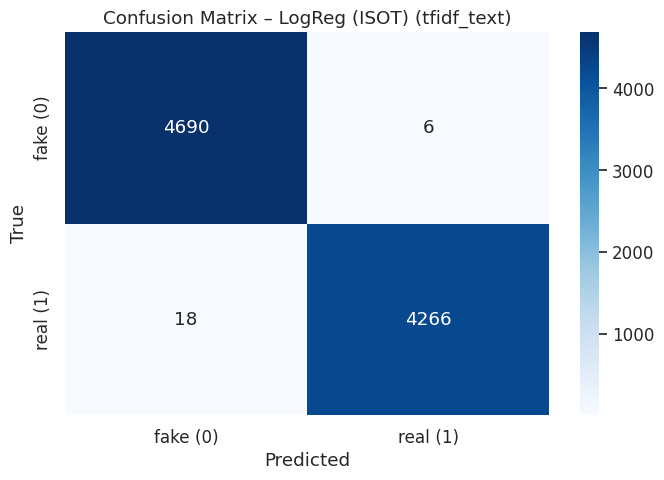

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best params for ISOT / LinearSVC (tfidf_text):
{'C': 10.0}
Best CV F1: 0.9935

===== LinearSVC (ISOT) on tfidf_text =====
Accuracy : 0.9958
Precision: 0.9953
Recall   : 0.9958
F1-score : 0.9956

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



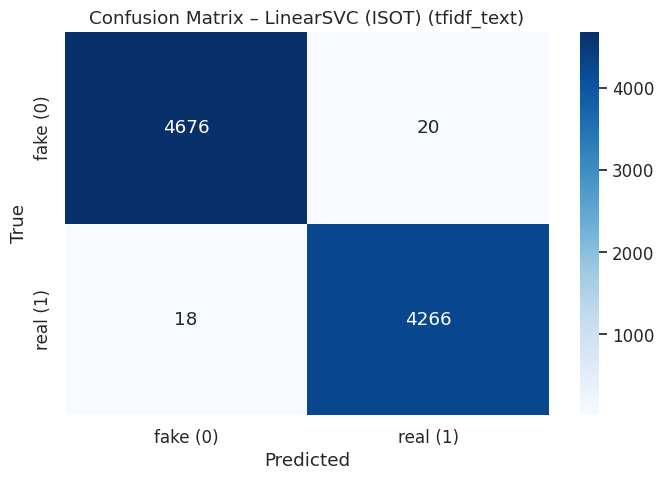

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best params for ISOT / RF (tfidf_text):
{'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}
Best CV F1: 0.9933

===== RandomForest (ISOT) on tfidf_text =====
Accuracy : 0.9970
Precision: 0.9958
Recall   : 0.9979
F1-score : 0.9969

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



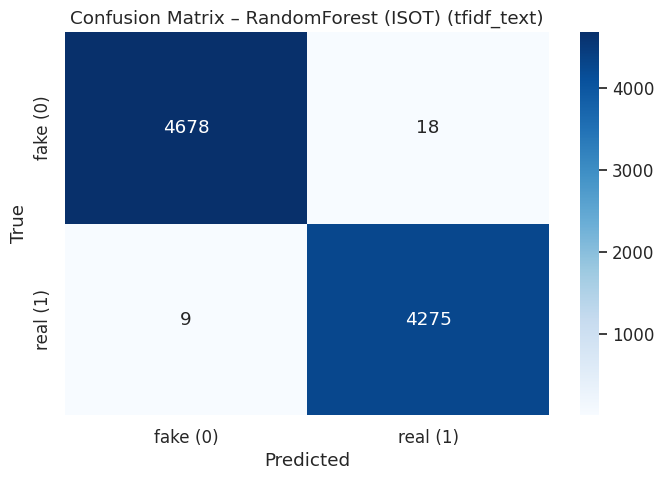


--- Feature space: cv_text ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for ISOT / LogReg (cv_text):
{'penalty': 'l2', 'C': 14.38449888287663}
Best CV F1: 0.9955

===== LogReg (ISOT) on cv_text =====
Accuracy : 0.9970
Precision: 0.9970
Recall   : 0.9967
F1-score : 0.9968

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



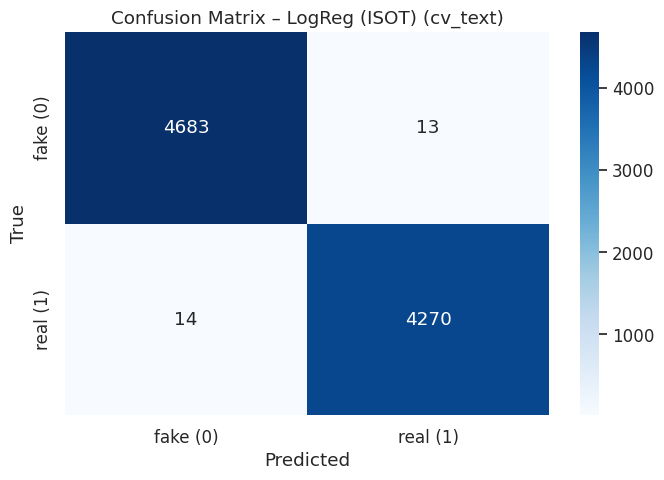

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Best params for ISOT / LinearSVC (cv_text):
{'C': 0.007742636826811269}
Best CV F1: 0.9955

===== LinearSVC (ISOT) on cv_text =====
Accuracy : 0.9968
Precision: 0.9967
Recall   : 0.9965
F1-score : 0.9966

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



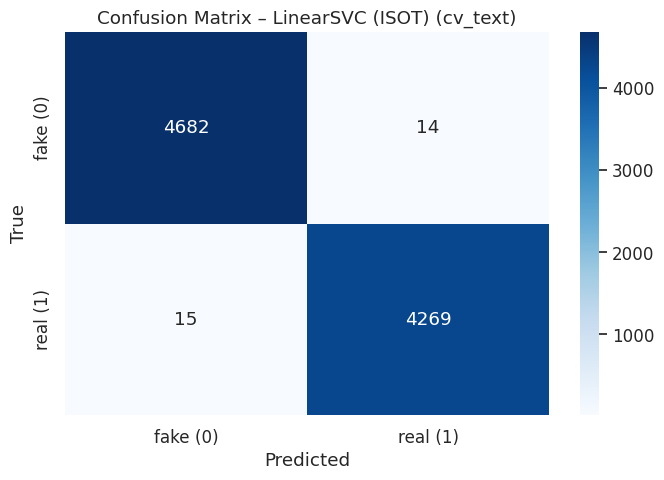

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best params for ISOT / RF (cv_text):
{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}
Best CV F1: 0.9940

===== RandomForest (ISOT) on cv_text =====
Accuracy : 0.9969
Precision: 0.9958
Recall   : 0.9977
F1-score : 0.9967

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



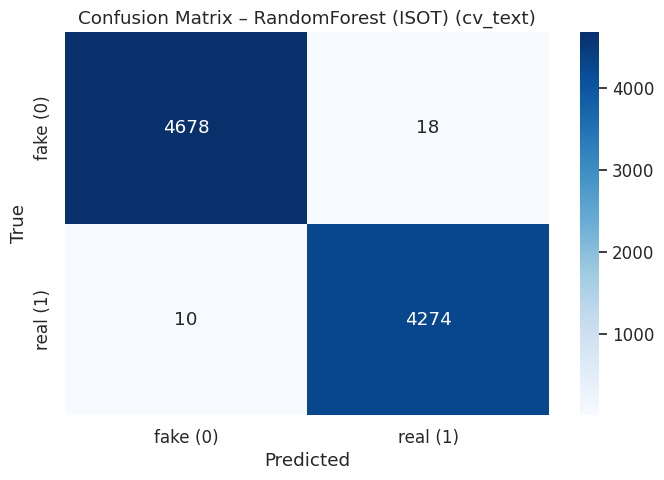


--- Feature space: lfs ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for ISOT / LogReg (lfs):
{'penalty': 'l1', 'C': 0.04281332398719394}
Best CV F1: 0.7998

===== LogReg (ISOT) on lfs =====
Accuracy : 0.7929
Precision: 0.7463
Recall   : 0.8571
F1-score : 0.7979

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.85      0.73      0.79      4696
    real (1)       0.75      0.86      0.80      4284

    accuracy                           0.79      8980
   macro avg       0.80      0.80      0.79      8980
weighted avg       0.80      0.79      0.79      8980



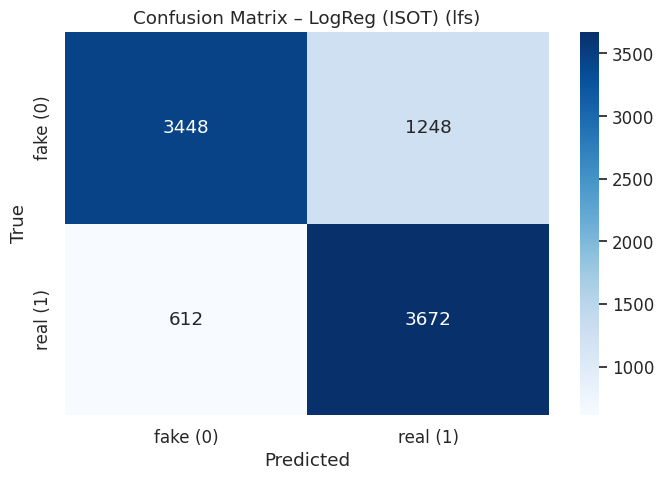

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Best params for ISOT / LinearSVC (lfs):
{'C': 10.0}
Best CV F1: 0.7989

===== LinearSVC (ISOT) on lfs =====
Accuracy : 0.7903
Precision: 0.7406
Recall   : 0.8625
F1-score : 0.7969

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.85      0.72      0.78      4696
    real (1)       0.74      0.86      0.80      4284

    accuracy                           0.79      8980
   macro avg       0.80      0.79      0.79      8980
weighted avg       0.80      0.79      0.79      8980



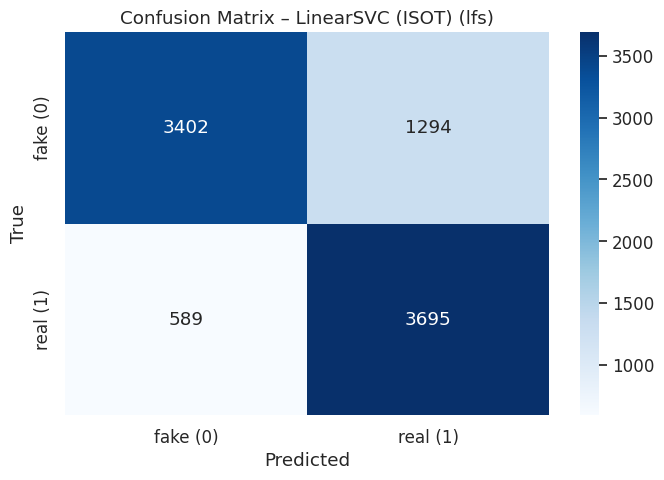

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params for ISOT / RF (lfs):
{'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None}
Best CV F1: 0.8781

===== RandomForest (ISOT) on lfs =====
Accuracy : 0.9003
Precision: 0.9024
Recall   : 0.8870
F1-score : 0.8946

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.90      0.91      0.91      4696
    real (1)       0.90      0.89      0.89      4284

    accuracy                           0.90      8980
   macro avg       0.90      0.90      0.90      8980
weighted avg       0.90      0.90      0.90      8980



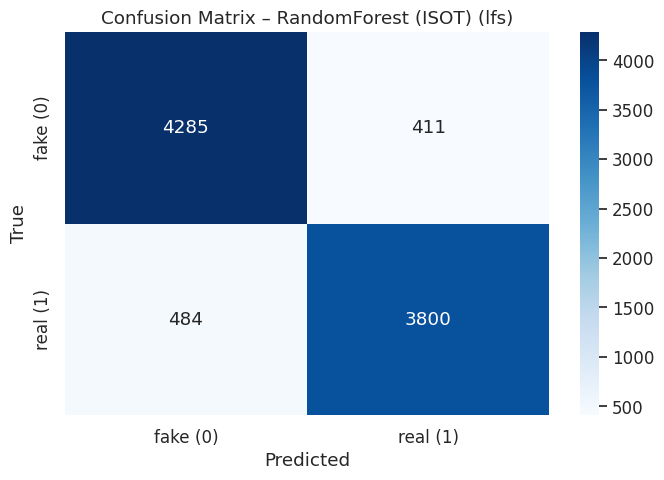


--- Feature space: lfs_cv ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for ISOT / LogReg (lfs_cv):
{'penalty': 'l2', 'C': 61.584821106602604}
Best CV F1: 0.9955

===== LogReg (ISOT) on lfs_cv =====
Accuracy : 0.9973
Precision: 0.9972
Recall   : 0.9972
F1-score : 0.9972

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



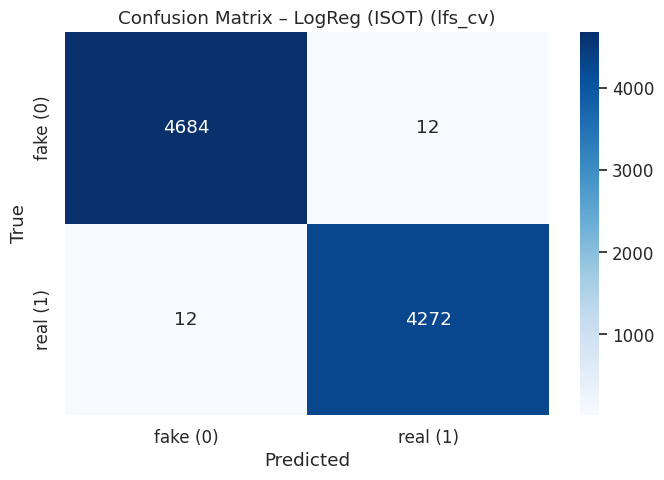

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Best params for ISOT / LinearSVC (lfs_cv):
{'C': 0.0027825594022071257}
Best CV F1: 0.9958

===== LinearSVC (ISOT) on lfs_cv =====
Accuracy : 0.9967
Precision: 0.9963
Recall   : 0.9967
F1-score : 0.9965

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



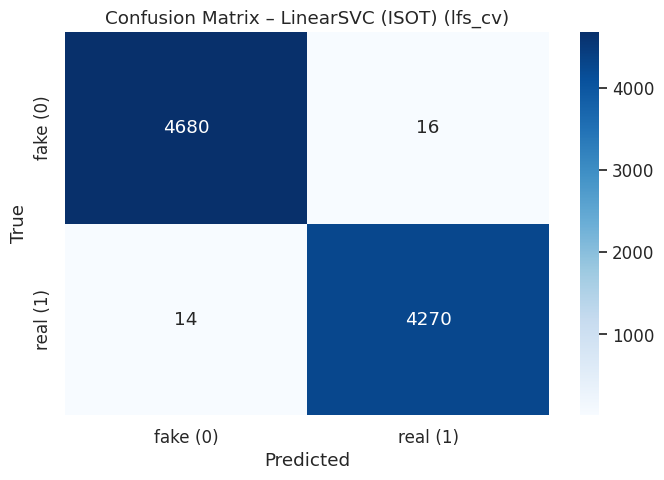

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params for ISOT / RF (lfs_cv):
{'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None}
Best CV F1: 0.9940

===== RandomForest (ISOT) on lfs_cv =====
Accuracy : 0.9967
Precision: 0.9965
Recall   : 0.9965
F1-score : 0.9965

Classification report:
              precision    recall  f1-score   support

    fake (0)       1.00      1.00      1.00      4696
    real (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



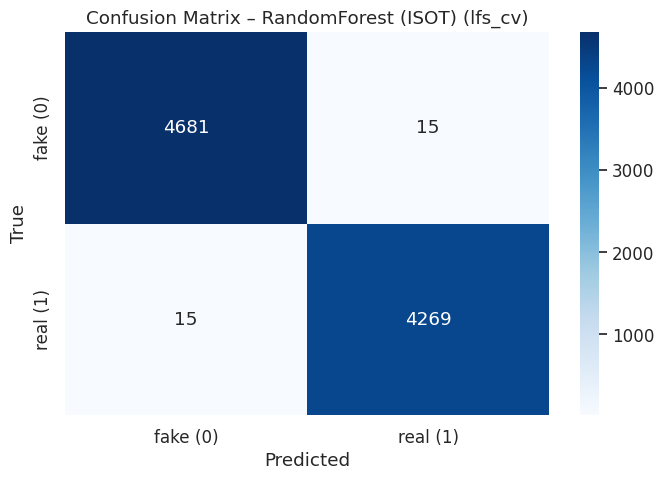



##########################
## Experiments on WELFake ##
##########################

--- Feature space: tfidf_text ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for WELFake / LogReg (tfidf_text):
{'penalty': 'l2', 'C': 100.0}
Best CV F1: 0.9589

===== LogReg (WELFake) on tfidf_text =====
Accuracy : 0.9650
Precision: 0.9571
Recall   : 0.9751
F1-score : 0.9660

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.97      0.95      0.96      7006
    real (1)       0.96      0.98      0.97      7302

    accuracy                           0.96     14308
   macro avg       0.97      0.96      0.96     14308
weighted avg       0.97      0.96      0.96     14308



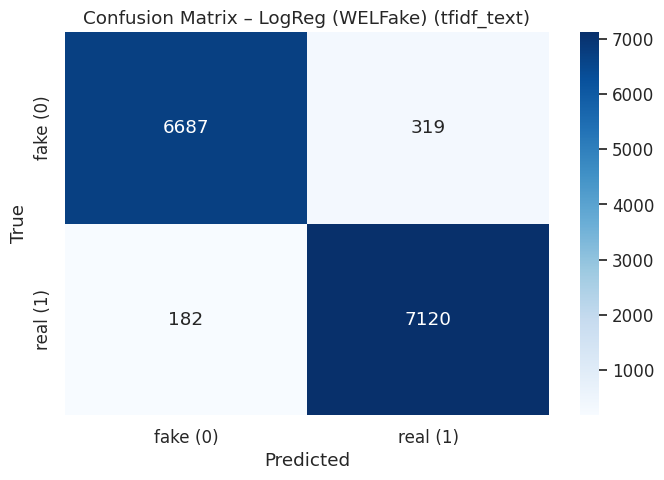

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best params for WELFake / LinearSVC (tfidf_text):
{'C': 1.2915496650148828}
Best CV F1: 0.9592

===== LinearSVC (WELFake) on tfidf_text =====
Accuracy : 0.9655
Precision: 0.9580
Recall   : 0.9751
F1-score : 0.9665

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.97      0.96      0.96      7006
    real (1)       0.96      0.98      0.97      7302

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



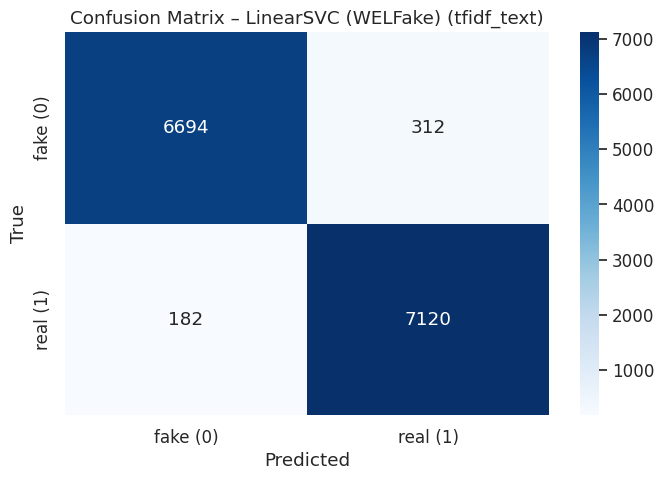

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best params for WELFake / RF (tfidf_text):
{'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}
Best CV F1: 0.9411

===== RandomForest (WELFake) on tfidf_text =====
Accuracy : 0.9481
Precision: 0.9365
Recall   : 0.9637
F1-score : 0.9499

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.96      0.93      0.95      7006
    real (1)       0.94      0.96      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



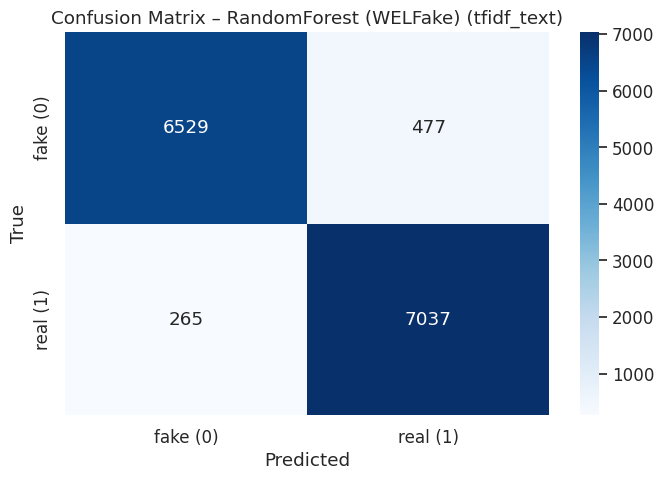


--- Feature space: cv_text ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for WELFake / LogReg (cv_text):
{'penalty': 'l1', 'C': 0.4832930238571752}
Best CV F1: 0.9555

===== LogReg (WELFake) on cv_text =====
Accuracy : 0.9608
Precision: 0.9503
Recall   : 0.9741
F1-score : 0.9621

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.97      0.95      0.96      7006
    real (1)       0.95      0.97      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



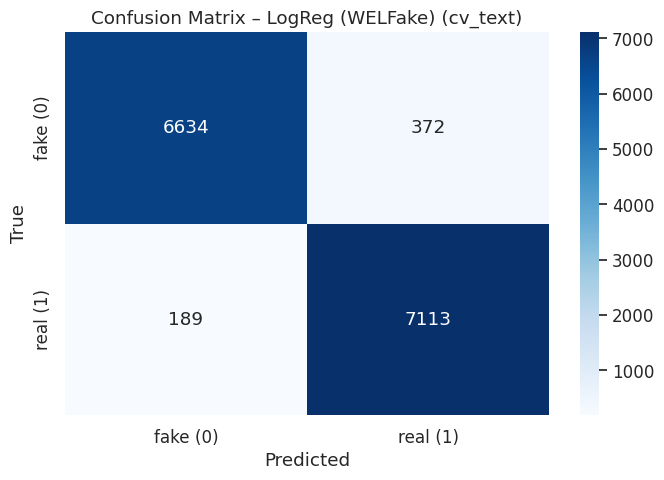

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Best params for WELFake / LinearSVC (cv_text):
{'C': 0.0027825594022071257}
Best CV F1: 0.9544

===== LinearSVC (WELFake) on cv_text =====
Accuracy : 0.9575
Precision: 0.9439
Recall   : 0.9747
F1-score : 0.9590

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.97      0.94      0.96      7006
    real (1)       0.94      0.97      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



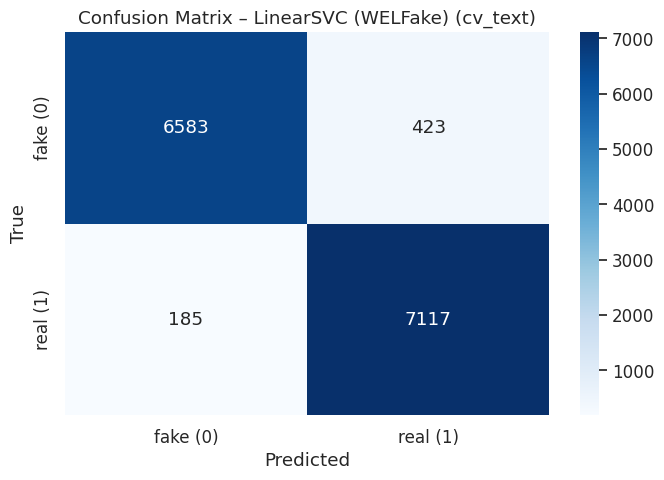

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params for WELFake / RF (cv_text):
{'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}
Best CV F1: 0.9434

===== RandomForest (WELFake) on cv_text =====
Accuracy : 0.9500
Precision: 0.9420
Recall   : 0.9611
F1-score : 0.9515

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.96      0.94      0.95      7006
    real (1)       0.94      0.96      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



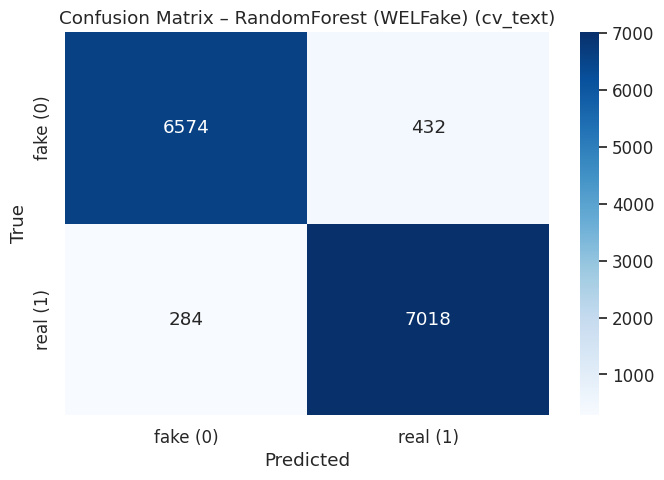


--- Feature space: lfs ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for WELFake / LogReg (lfs):
{'penalty': 'l2', 'C': 61.584821106602604}
Best CV F1: 0.7296

===== LogReg (WELFake) on lfs =====
Accuracy : 0.7317
Precision: 0.7623
Recall   : 0.6891
F1-score : 0.7239

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.71      0.78      0.74      7006
    real (1)       0.76      0.69      0.72      7302

    accuracy                           0.73     14308
   macro avg       0.73      0.73      0.73     14308
weighted avg       0.73      0.73      0.73     14308



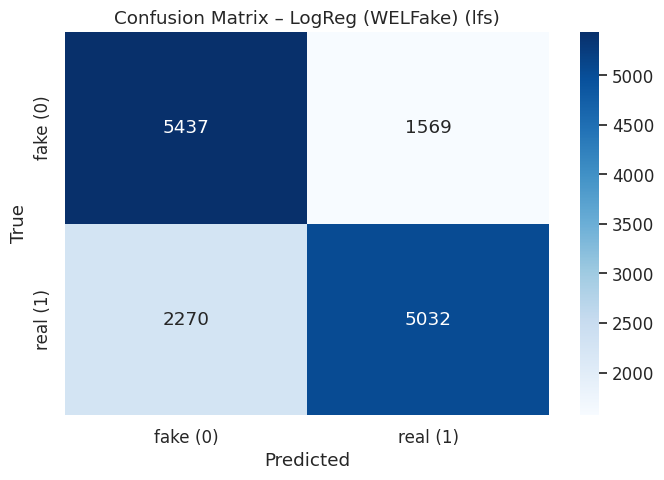

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Best params for WELFake / LinearSVC (lfs):
{'C': 10.0}
Best CV F1: 0.7259

===== LinearSVC (WELFake) on lfs =====
Accuracy : 0.7286
Precision: 0.7634
Recall   : 0.6786
F1-score : 0.7185

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.70      0.78      0.74      7006
    real (1)       0.76      0.68      0.72      7302

    accuracy                           0.73     14308
   macro avg       0.73      0.73      0.73     14308
weighted avg       0.73      0.73      0.73     14308



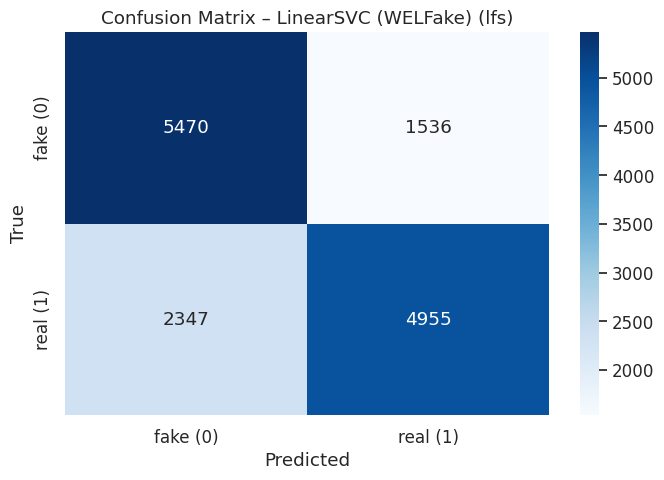

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params for WELFake / RF (lfs):
{'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}
Best CV F1: 0.8343

===== RandomForest (WELFake) on lfs =====
Accuracy : 0.8458
Precision: 0.8448
Recall   : 0.8548
F1-score : 0.8498

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.85      0.84      0.84      7006
    real (1)       0.84      0.85      0.85      7302

    accuracy                           0.85     14308
   macro avg       0.85      0.85      0.85     14308
weighted avg       0.85      0.85      0.85     14308



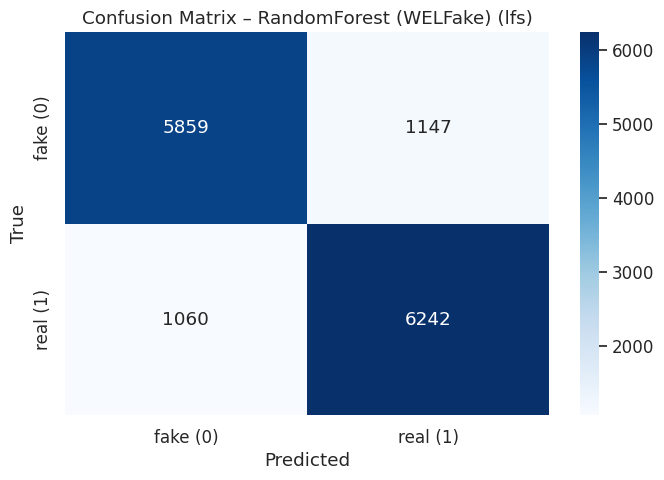


--- Feature space: lfs_cv ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best params for WELFake / LogReg (lfs_cv):
{'penalty': 'l1', 'C': 0.4832930238571752}
Best CV F1: 0.9581

===== LogReg (WELFake) on lfs_cv =====
Accuracy : 0.9625
Precision: 0.9523
Recall   : 0.9755
F1-score : 0.9637

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.97      0.95      0.96      7006
    real (1)       0.95      0.98      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



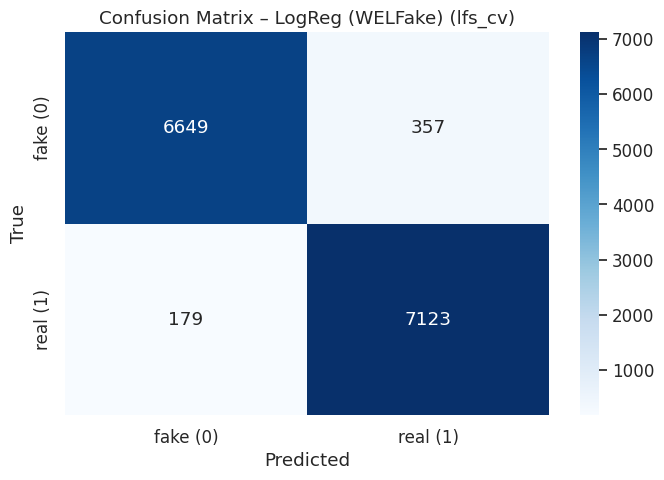

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Best params for WELFake / LinearSVC (lfs_cv):
{'C': 0.0027825594022071257}
Best CV F1: 0.9563

===== LinearSVC (WELFake) on lfs_cv =====
Accuracy : 0.9600
Precision: 0.9476
Recall   : 0.9756
F1-score : 0.9614

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.97      0.94      0.96      7006
    real (1)       0.95      0.98      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



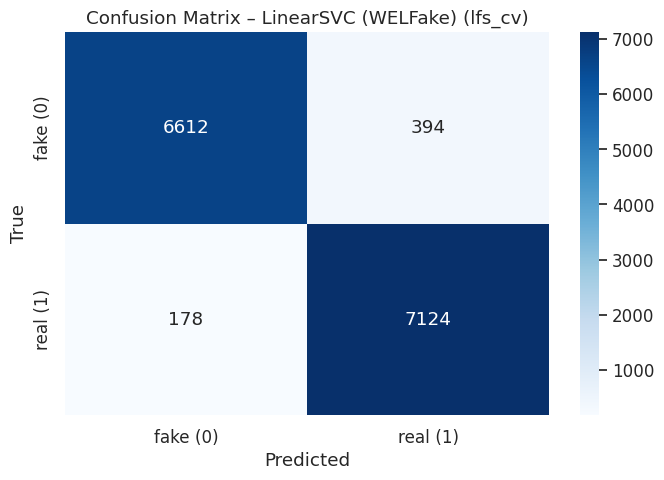

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params for WELFake / RF (lfs_cv):
{'n_estimators': 300, 'min_samples_split': 10, 'max_depth': None}
Best CV F1: 0.9448

===== RandomForest (WELFake) on lfs_cv =====
Accuracy : 0.9509
Precision: 0.9435
Recall   : 0.9614
F1-score : 0.9524

Classification report:
              precision    recall  f1-score   support

    fake (0)       0.96      0.94      0.95      7006
    real (1)       0.94      0.96      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



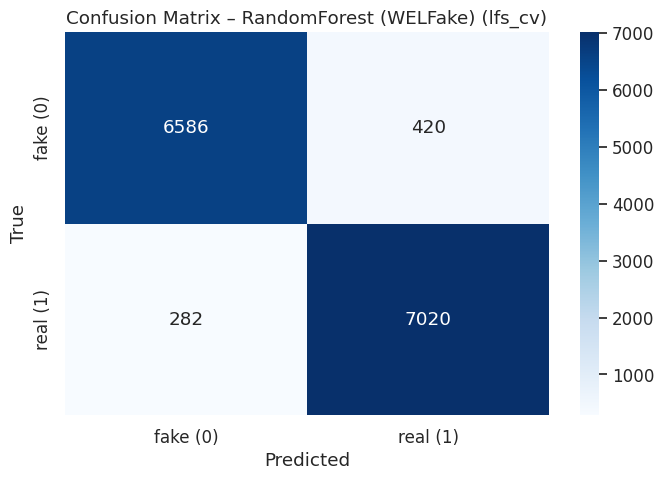

,model,features,accuracy,precision,recall,f1,dataset
0,LogReg (ISOT),tfidf_text,0.997327,0.998596,0.995798,0.997195,ISOT
1,LinearSVC (ISOT),tfidf_text,0.995768,0.995334,0.995798,0.995566,ISOT
2,RandomForest (ISOT),tfidf_text,0.996993,0.995807,0.997899,0.996852,ISOT
3,LogReg (ISOT),cv_text,0.996993,0.996965,0.996732,0.996848,ISOT
4,LinearSVC (ISOT),cv_text,0.996771,0.996731,0.996499,0.996615,ISOT
5,RandomForest (ISOT),cv_text,0.996882,0.995806,0.997666,0.996735,ISOT
6,LogReg (ISOT),lfs,0.792873,0.746341,0.857143,0.797914,ISOT
7,LinearSVC (ISOT),lfs,0.790312,0.740629,0.862512,0.796937,ISOT
8,RandomForest (ISOT),lfs,0.900334,0.902398,0.887021,0.894644,ISOT
9,LogReg (ISOT),lfs_cv,0.997327,0.997199,0.997199,0.997199,ISOT


In [17]:
# ======================================
# 10.4 Run experiments on both datasets
# ======================================

metrics_isot, best_models_isot = run_experiments_for_dataset(
    "ISOT", isot_df, features_isot, idx_train_isot, idx_test_isot
)

metrics_welfake, best_models_welfake = run_experiments_for_dataset(
    "WELFake", welfake_df, features_welfake, idx_train_welfake, idx_test_welfake
)

metrics_isot["dataset"] = "ISOT"
metrics_welfake["dataset"] = "WELFake"

metrics_all = pd.concat([metrics_isot, metrics_welfake], ignore_index=True)
metrics_all

## 11. WELFake-style tri-view voting ensemble

Following the WELFake algorithm, which combines TF-IDF, CV, and LFS-based embedding outputs with a **hard voting classifier**, :contentReference[oaicite:10]{index=10} we now:

- Select the **best-performing classifier** (highest F1) for each feature space:
  - TF-IDF
  - CV
  - LFS+CV
- Build a **VotingClassifier** over these three models for each dataset.



### Evaluating tri-view ensemble on ISOT ###
Ensemble Accuracy : 0.9973
Ensemble Precision: 0.9972
Ensemble Recall   : 0.9972
Ensemble F1-score : 0.9972


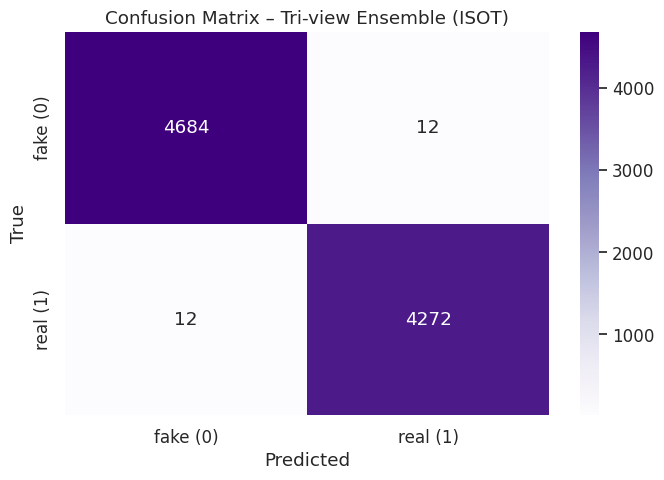


### Evaluating tri-view ensemble on WELFake ###
Ensemble Accuracy : 0.9645
Ensemble Precision: 0.9548
Ensemble Recall   : 0.9767
Ensemble F1-score : 0.9656


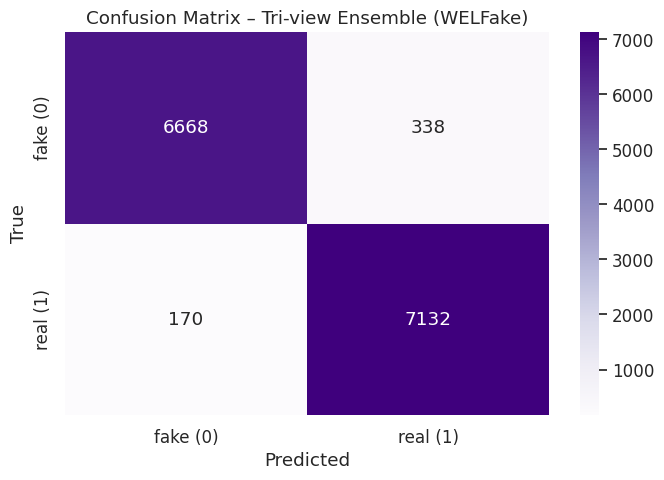

,model,features,accuracy,precision,recall,f1,dataset
0,LogReg (ISOT),tfidf_text,0.997327,0.998596,0.995798,0.997195,ISOT
1,LinearSVC (ISOT),tfidf_text,0.995768,0.995334,0.995798,0.995566,ISOT
2,RandomForest (ISOT),tfidf_text,0.996993,0.995807,0.997899,0.996852,ISOT
3,LogReg (ISOT),cv_text,0.996993,0.996965,0.996732,0.996848,ISOT
4,LinearSVC (ISOT),cv_text,0.996771,0.996731,0.996499,0.996615,ISOT
5,RandomForest (ISOT),cv_text,0.996882,0.995806,0.997666,0.996735,ISOT
6,LogReg (ISOT),lfs,0.792873,0.746341,0.857143,0.797914,ISOT
7,LinearSVC (ISOT),lfs,0.790312,0.740629,0.862512,0.796937,ISOT
8,RandomForest (ISOT),lfs,0.900334,0.902398,0.887021,0.894644,ISOT
9,LogReg (ISOT),lfs_cv,0.997327,0.997199,0.997199,0.997199,ISOT


In [18]:
# ==================================
# 11. Build & evaluate voting ensembles
# ==================================


def build_voting_ensemble(
    dataset_name, df, features_dict, best_models_dict, idx_train, idx_test
):
    y = df["label"].values
    y_train = y[idx_train]
    y_test = y[idx_test]

    # For each feature space, pick the model with best F1 from metrics_all
    subset = metrics_all[metrics_all["dataset"] == dataset_name]
    feature_spaces = ["tfidf_text", "cv_text", "lfs_cv"]

    estimators = []
    for feat in feature_spaces:
        best_row = (
            subset[subset["features"] == feat]
            .sort_values("f1", ascending=False)
            .iloc[0]
        )
        model_name = best_row["model"].split(" ")[
            0
        ]  # LogReg / LinearSVC / RandomForest
        key = (dataset_name, model_name, feat)
        base_clf = best_models_dict[key]

        # Refit base_clf on full training data for that feature space
        X_train, X_test, _ = features_dict[feat]
        X_train_full = X_train  # already using train indices
        base_clf.fit(X_train_full, y_train)

        estimators.append((f"{model_name}_{feat}", base_clf))

    ensemble = VotingClassifier(estimators=estimators, voting="hard")

    # Build concatenated feature space for ensemble: we just reuse one of the spaces
    # and rely on each estimator using its own internal features (since we refit each separately).
    # To keep it simple, we evaluate ensemble on predictions (requires manual voting):

    print(f"\n### Evaluating tri-view ensemble on {dataset_name} ###")
    X_test_dict = {feat: features_dict[feat][1] for feat in feature_spaces}

    # Manual majority voting because each estimator sees only its own X
    preds = []
    for feat, (name, clf) in zip(feature_spaces, estimators):
        X_test_feat = X_test_dict[feat]
        preds.append(clf.predict(X_test_feat))

    preds = np.vstack(preds)  # shape: (n_models, n_samples)
    # Majority vote (break ties in favor of class 1 or 0; here we choose 1)
    votes_sum = preds.sum(axis=0)
    majority_pred = (votes_sum >= (len(estimators) / 2)).astype(int)

    acc = accuracy_score(y_test, majority_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, majority_pred, average="binary", pos_label=1
    )

    print(f"Ensemble Accuracy : {acc:.4f}")
    print(f"Ensemble Precision: {prec:.4f}")
    print(f"Ensemble Recall   : {rec:.4f}")
    print(f"Ensemble F1-score : {f1:.4f}")

    cm = confusion_matrix(y_test, majority_pred)
    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Purples",
        xticklabels=["fake (0)", "real (1)"],
        yticklabels=["fake (0)", "real (1)"],
    )
    plt.title(f"Confusion Matrix – Tri-view Ensemble ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    metrics = {
        "model": "TriViewEnsemble",
        "features": "tfidf+cv+lfs_cv",
        "dataset": dataset_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    return metrics


ensemble_isot_metrics = build_voting_ensemble(
    "ISOT", isot_df, features_isot, best_models_isot, idx_train_isot, idx_test_isot
)

ensemble_welfake_metrics = build_voting_ensemble(
    "WELFake",
    welfake_df,
    features_welfake,
    best_models_welfake,
    idx_train_welfake,
    idx_test_welfake,
)

metrics_all = pd.concat(
    [metrics_all, pd.DataFrame([ensemble_isot_metrics, ensemble_welfake_metrics])],
    ignore_index=True,
)
metrics_all

## 12. Cross-dataset generalization experiments

To test robustness (and extend WELFake’s adversarial validation idea), :contentReference[oaicite:11]{index=11} we evaluate:

1. Train on **ISOT**, test on **WELFake**.  
2. Train on **WELFake**, test on **ISOT**.

We use the **best single model + feature space** (highest F1) for each source dataset.




=== Cross-dataset: ISOT ➜ WELFake ===
Using source config: model=LogReg, features=lfs_cv
Accuracy : 0.1844
Precision: 0.0169
Recall   : 0.0105
F1-score : 0.0129


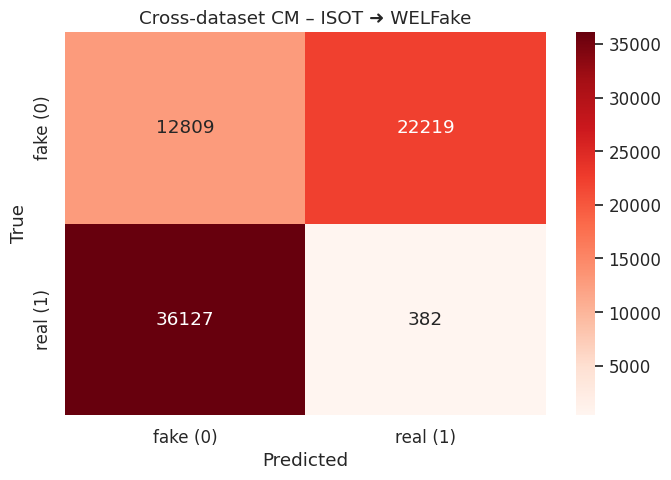



=== Cross-dataset: WELFake ➜ ISOT ===
Using source config: model=LinearSVC, features=tfidf_text
Accuracy : 0.0007
Precision: 0.0002
Recall   : 0.0002
F1-score : 0.0002


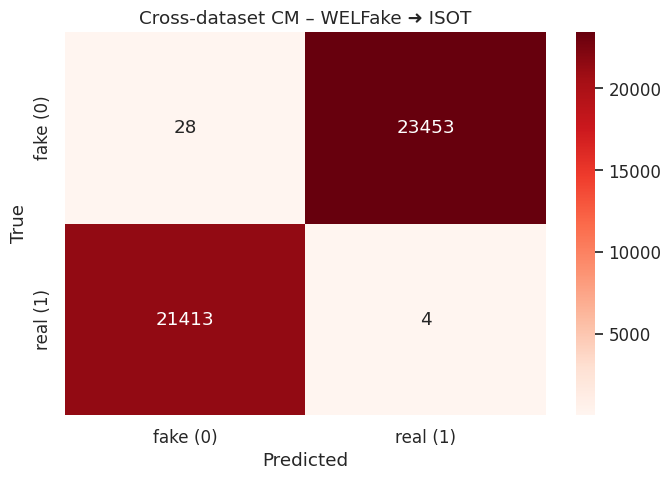

,model,features,source_dataset,target_dataset,accuracy,precision,recall,f1
0,LogReg,lfs_cv,ISOT,WELFake,0.184394,0.016902,0.010463,0.012925
1,LinearSVC,tfidf_text,WELFake,ISOT,0.000713,0.000171,0.000187,0.000178


In [19]:
# ==================================
# 12. Cross-dataset generalization
# ==================================


def cross_dataset_eval(
    source_name,
    target_name,
    source_df,
    target_df,
    best_models_dict_source,
    best_feature_spaces_source,
):
    """
    Train on full source training data, test on full target data
    using selected feature space (e.g., 'lfs_cv').
    """
    print(f"\n\n=== Cross-dataset: {source_name} ➜ {target_name} ===")

    # Choose best model & feature space for source
    subset = metrics_all[metrics_all["dataset"] == source_name]
    best_row = subset.sort_values("f1", ascending=False).iloc[0]
    feat = best_row["features"]
    model_name = best_row["model"].split(" ")[0]

    print(f"Using source config: model={model_name}, features={feat}")

    key = (source_name, model_name, feat)
    base_clf = best_models_dict_source[key]

    # Build feature space on SOURCE & TARGET using same vectorizer where needed
    # For TF-IDF / CV, we need to refit vectorizer on SOURCE text, then transform TARGET text.

    # Build LFS for both
    X_lfs_source_scaled = (
        X_lfs_isot_scaled if source_name == "ISOT" else X_lfs_welfake_scaled
    )
    X_lfs_target_scaled = (
        X_lfs_welfake_scaled if source_name == "ISOT" else X_lfs_isot_scaled
    )

    source_texts = source_df["text_clean"].tolist()
    target_texts = target_df["text_clean"].tolist()

    if feat == "tfidf_text":
        vec = build_tfidf_vectorizer()
        X_src, X_tgt, vec = fit_and_transform_vectorizer(
            vec, source_texts, target_texts
        )
    elif feat == "cv_text":
        vec = build_cv_vectorizer()
        X_src, X_tgt, vec = fit_and_transform_vectorizer(
            vec, source_texts, target_texts
        )
    elif feat == "lfs":
        X_src = csr_matrix(X_lfs_source_scaled)
        X_tgt = csr_matrix(X_lfs_target_scaled)
    elif feat == "lfs_cv":
        vec = build_cv_vectorizer()
        X_src_cv, X_tgt_cv, vec = fit_and_transform_vectorizer(
            vec, source_texts, target_texts
        )
        X_src_lfs = csr_matrix(X_lfs_source_scaled)
        X_tgt_lfs = csr_matrix(X_lfs_target_scaled)
        X_src = hstack([X_src_lfs, X_src_cv])
        X_tgt = hstack([X_tgt_lfs, X_tgt_cv])
    else:
        raise ValueError(f"Unknown feature space: {feat}")

    y_src = source_df["label"].values
    y_tgt = target_df["label"].values

    # Fit on entire source dataset
    base_clf.fit(X_src, y_src)

    # Evaluate on target
    y_pred = base_clf.predict(X_tgt)
    acc = accuracy_score(y_tgt, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_tgt, y_pred, average="binary", pos_label=1
    )

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    cm = confusion_matrix(y_tgt, y_pred)
    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Reds",
        xticklabels=["fake (0)", "real (1)"],
        yticklabels=["fake (0)", "real (1)"],
    )
    plt.title(f"Cross-dataset CM – {source_name} ➜ {target_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "model": model_name,
        "features": feat,
        "source_dataset": source_name,
        "target_dataset": target_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }


cross1 = cross_dataset_eval(
    "ISOT",
    "WELFake",
    isot_df,
    welfake_df,
    best_models_isot,
    features_isot,
)

cross2 = cross_dataset_eval(
    "WELFake",
    "ISOT",
    welfake_df,
    isot_df,
    best_models_welfake,
    features_welfake,
)

cross_df = pd.DataFrame([cross1, cross2])
cross_df

In [20]:
# ==========================================
# 13. Save metrics, models, and configuration
# ==========================================

# Save metrics
metrics_all.to_csv(RESULTS_DIR / "baseline_and_ensemble_metrics.csv", index=False)
cross_df.to_csv(RESULTS_DIR / "cross_dataset_metrics.csv", index=False)

print("Saved metrics to:", RESULTS_DIR)

# Example: save a couple of best models (e.g., best ISOT LFS+CV SVM, best WELFake LFS+CV SVM)
for key, model in best_models_isot.items():
    dataset_name, model_name, feat = key
    fname = MODELS_DIR / f"{dataset_name}_{model_name}_{feat}.joblib"
    joblib.dump(model, fname)

for key, model in best_models_welfake.items():
    dataset_name, model_name, feat = key
    fname = MODELS_DIR / f"{dataset_name}_{model_name}_{feat}.joblib"
    joblib.dump(model, fname)

print("Saved individual models to:", MODELS_DIR)

Saved metrics to: /kaggle/working
Saved individual models to: /kaggle/working


## 14. Summary & next steps

This notebook implements a **WELFake-inspired**, but extended, experimental pipeline:

- Two datasets: **ISOT** and **WELFake**
- Linguistic feature sets (LFS) + bag-of-words representations (TF-IDF, CV)
- Multiple classifiers (LogReg, LinearSVC, RandomForest)
- Randomized hyperparameter search with stratified CV
- Hard-voting **tri-view ensemble** over TF-IDF, CV, and LFS+CV
- **Cross-dataset generalization** experiments

You can now:

- Turn `metrics_all` and `cross_df` into tables for your paper.
- Compare your best WELFake-style model against reported WELFake accuracy (~96.7% on WELFake). :contentReference[oaicite:12]{index=12}  
- Write the **Experiments** and **Results** sections based directly on these outputs.
